In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [2]:
%load_ext lab_black
pd.set_option("display.max_columns", None)

The features: \
**customer_id :** id of the credit card holder\
**balance_account :** balance amount left in the account to make purchases at the end of the 6-month period\
**purchases_amount :** amount of purchases made from account\
**paid_advance :** number of transactions made with “Cash in Advance” method\
**full_purchases :** maximum purchase amount done in full payment\
**balance_frequency_update :** how frequently the balance has been updated, score between 0 and 1 (1 = frequently - updated, 0 = not frequently updated)\
**installments :** amount of purchases done in installments\
**purchases_frequency :** how frequently the purchases are being made, score between 0 and 1 (1 = frequently - - purchased, 0 = not frequently purchased)\
**full_purchases_frequency :** how frequently purchases are happening in full payment (1 = frequently purchased, - 0 = not frequently purchased)\
**purchases_installments_frequency :** how frequently purchases in installments are being done (1 = frequently - done, 0 = not frequently done)\
**cash_advance_frequency :** how frequently the cash in advance being paid\
**nr_cash_advances :** cash in advance given by the user\
**nr_purchases :** number of purchase transactions made\
**credit_limit :** limit of credit card for user\
**fixed_rate_period :** duration of fixed interest rate of credit card service for user (in months)\
**payments :** amount of payment done by user\
**min_payments :** minimum amount of payments made by user\
**full_payment_prc :** percent of full payment paid by user

In [3]:
path = "/Users/ozgunhaznedar/Desktop/SIT/data/card_transactions.csv"
df = pd.read_csv(path, na_values=["?", ""])
df

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.60,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.30,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.00,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.00,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,zdVfd3CYHYBjf61b,1127.607606,0.00,271.093275,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.083333,1,0,8500.0,12,662.387331,260.277533,0.000000
8496,JGghMowcxhfbVGKm,21.409828,149.71,0.000000,0.00,1.000000,149.71,0.916667,0.000000,0.916667,0.000000,0,11,1500.0,12,141.974905,150.500248,0.166667
8497,5GrEtC6ncxuLpnXZ,0.000000,0.00,253.887233,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.111111,1,0,500.0,9,2437.932505,NaN,0.000000
8498,Ox7ETtYHjE2uo4Xo,1646.384530,1047.34,146.650389,1047.34,1.000000,0.00,0.583333,0.583333,0.000000,0.166667,2,51,3000.0,12,462.848132,497.408854,0.000000


In [4]:
df.info()  # there is missin data in credit_limit and min_payments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       8500 non-null   object 
 1   balance_account                   8500 non-null   float64
 2   purchases_amount                  8500 non-null   float64
 3   paid_advance                      8500 non-null   float64
 4   full_purchases                    8500 non-null   float64
 5   balance_frequency_update          8500 non-null   float64
 6   installments                      8500 non-null   float64
 7   purchases_frequency               8500 non-null   float64
 8   full_purchases_frequency          8500 non-null   float64
 9   purchases_installments_frequency  8500 non-null   float64
 10  cash_advance_frequency            8500 non-null   float64
 11  nr_cash_advances                  8500 non-null   int64  
 12  nr_pur

In [5]:
df.set_index("customer_id", inplace=True)

In [6]:
# impute missing numerical values with knn
num_cols = df.columns
knn_imp = KNNImputer(n_neighbors=5)
df = pd.DataFrame(knn_imp.fit_transform(df), columns=num_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   balance_account                   8500 non-null   float64
 1   purchases_amount                  8500 non-null   float64
 2   paid_advance                      8500 non-null   float64
 3   full_purchases                    8500 non-null   float64
 4   balance_frequency_update          8500 non-null   float64
 5   installments                      8500 non-null   float64
 6   purchases_frequency               8500 non-null   float64
 7   full_purchases_frequency          8500 non-null   float64
 8   purchases_installments_frequency  8500 non-null   float64
 9   cash_advance_frequency            8500 non-null   float64
 10  nr_cash_advances                  8500 non-null   float64
 11  nr_purchases                      8500 non-null   float64
 12  credit

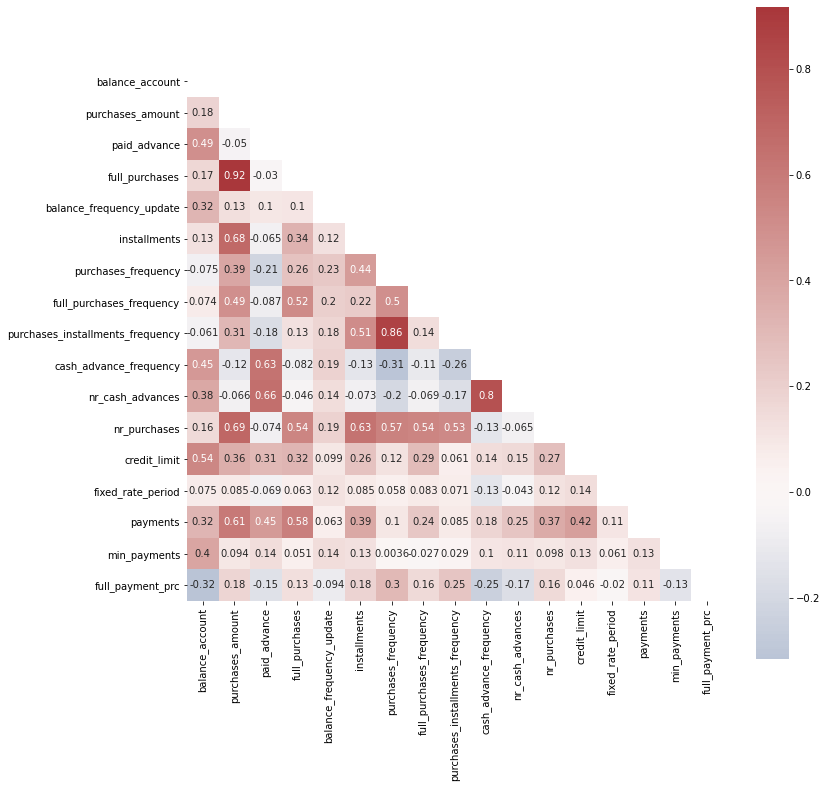

In [7]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(corr, mask=mask, square=True, cmap="vlag", center=0, annot=True)

In [8]:
# drop variables that are correlated higher than 0.85
corr_upper = np.triu(corr, k=1)
idx = corr[(abs(corr_upper) > 0.85).any(axis=1)].index
df.drop(idx, axis=1, inplace=True)
df.columns

Index(['balance_account', 'paid_advance', 'full_purchases',
       'balance_frequency_update', 'installments', 'full_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'nr_cash_advances', 'nr_purchases', 'credit_limit', 'fixed_rate_period',
       'payments', 'min_payments', 'full_payment_prc'],
      dtype='object')

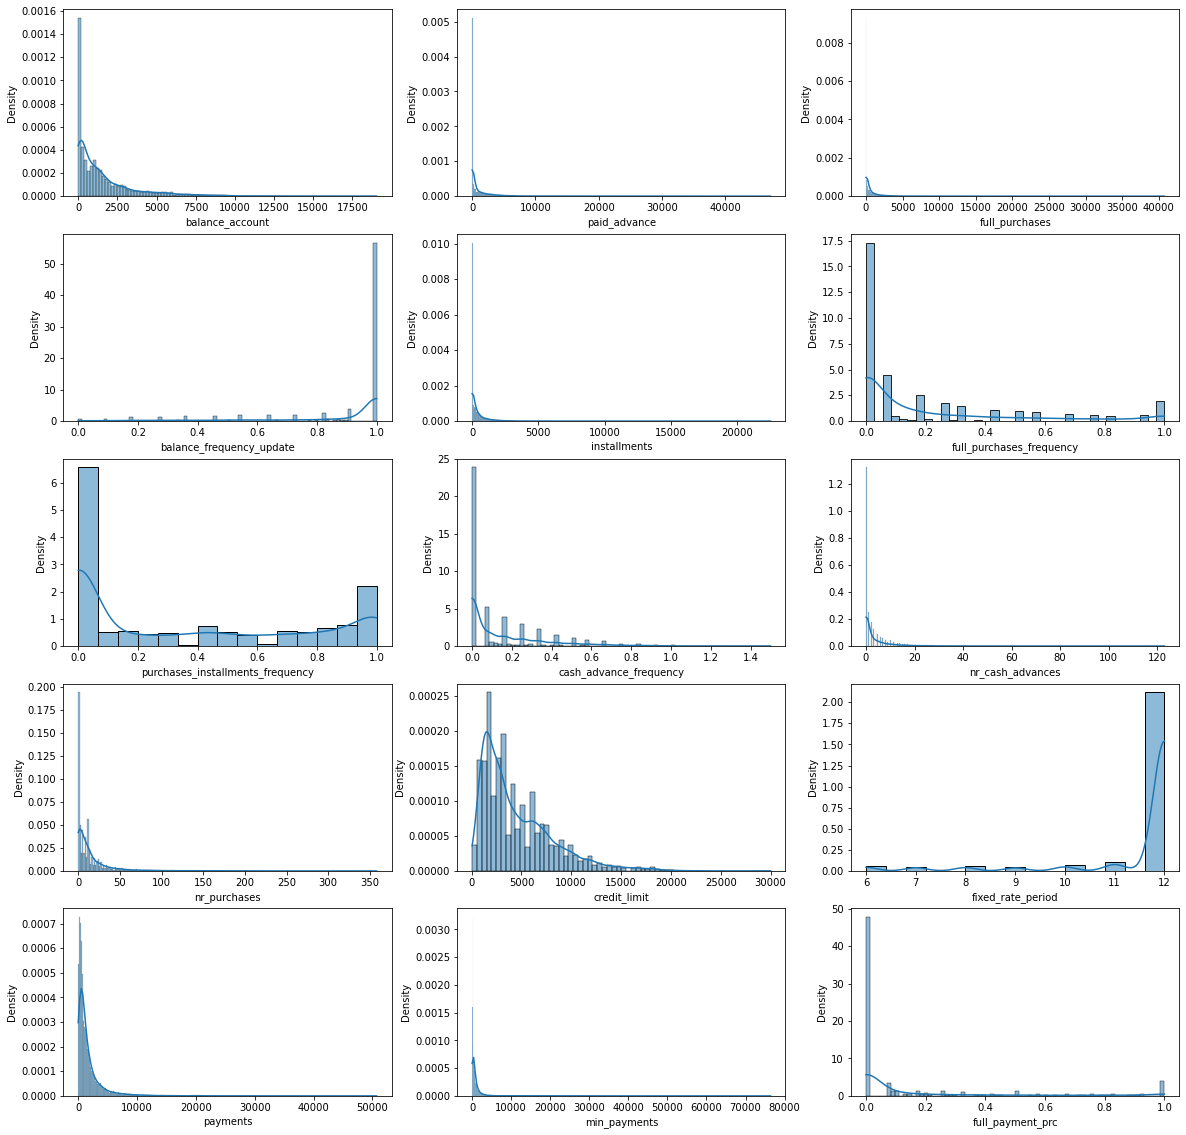

In [9]:
fig, axs = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(20, 20))
for index, name in enumerate(df.columns):
    col = index % 3
    row = (index - col) // 3
    ax = axs[row][col]
    sns.histplot(ax=ax, data=df, x=name, kde=True, stat="density")

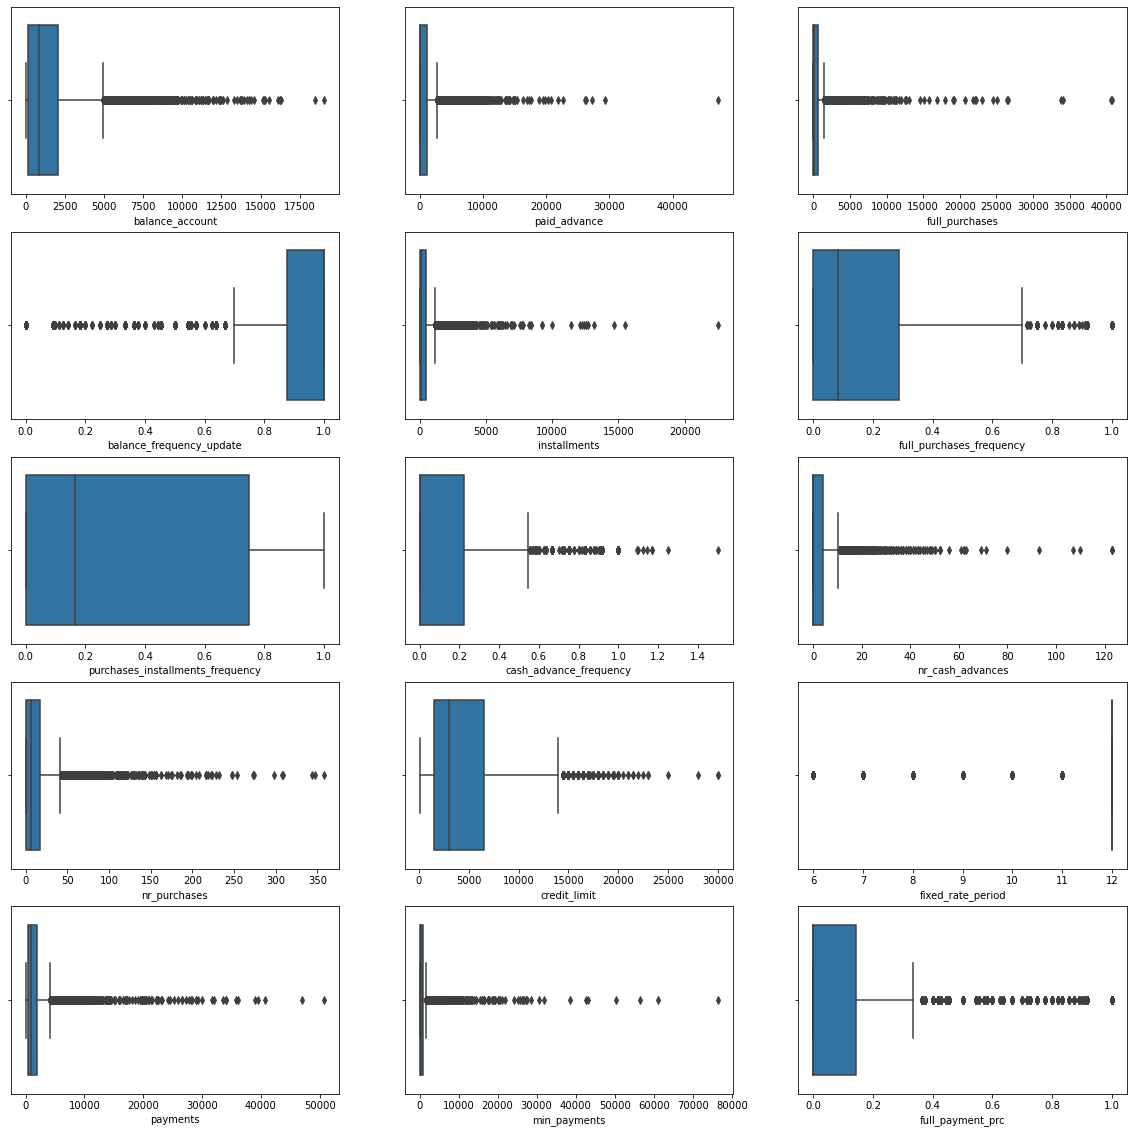

In [10]:
fig, axs = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(20, 20))
for index, name in enumerate(df.columns):
    col = index % 3
    row = (index - col) // 3
    ax = axs[row][col]
    sns.boxplot(ax=ax, data=df, x=name)

In [11]:
df.columns

Index(['balance_account', 'paid_advance', 'full_purchases',
       'balance_frequency_update', 'installments', 'full_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'nr_cash_advances', 'nr_purchases', 'credit_limit', 'fixed_rate_period',
       'payments', 'min_payments', 'full_payment_prc'],
      dtype='object')

In [12]:
columns_to_scale = [
    "balance_account",
    "paid_advance",
    "full_purchases",
    "installments",
    "nr_cash_advances",
    "nr_purchases",
    "credit_limit",
    "fixed_rate_period",
    "payments",
    "min_payments",
]

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

subset_df = df[columns_to_scale].copy()  # could not use timestamp

mms = MinMaxScaler(feature_range=(0, 1))
subset_df[columns_to_scale] = mms.fit_transform(subset_df)
subset_df.head()

,balance_account,paid_advance,full_purchases,installments,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments
0,0.000488,0.000000,0.000000,0.004782,0.00000,0.027933,0.031720,0.833333,0.001772,0.001174
1,0.002766,0.000000,0.000000,0.006680,0.00000,0.016760,0.031720,0.000000,0.001079,0.001085
2,0.071459,0.009819,0.000000,0.000000,0.04878,0.000000,0.048414,0.833333,0.005974,0.005808
3,0.106161,0.000000,0.008910,0.000000,0.00000,0.036313,0.065109,1.000000,0.013884,0.010416
4,0.001172,0.024652,0.002331,0.000000,0.02439,0.002793,0.081803,1.000000,0.080720,0.000525


In [14]:
df.drop(columns_to_scale, axis=1, inplace=True)

In [15]:
df = df.join(subset_df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   balance_frequency_update          8500 non-null   float64
 1   full_purchases_frequency          8500 non-null   float64
 2   purchases_installments_frequency  8500 non-null   float64
 3   cash_advance_frequency            8500 non-null   float64
 4   full_payment_prc                  8500 non-null   float64
 5   balance_account                   8500 non-null   float64
 6   paid_advance                      8500 non-null   float64
 7   full_purchases                    8500 non-null   float64
 8   installments                      8500 non-null   float64
 9   nr_cash_advances                  8500 non-null   float64
 10  nr_purchases                      8500 non-null   float64
 11  credit_limit                      8500 non-null   float64
 12  fixed_

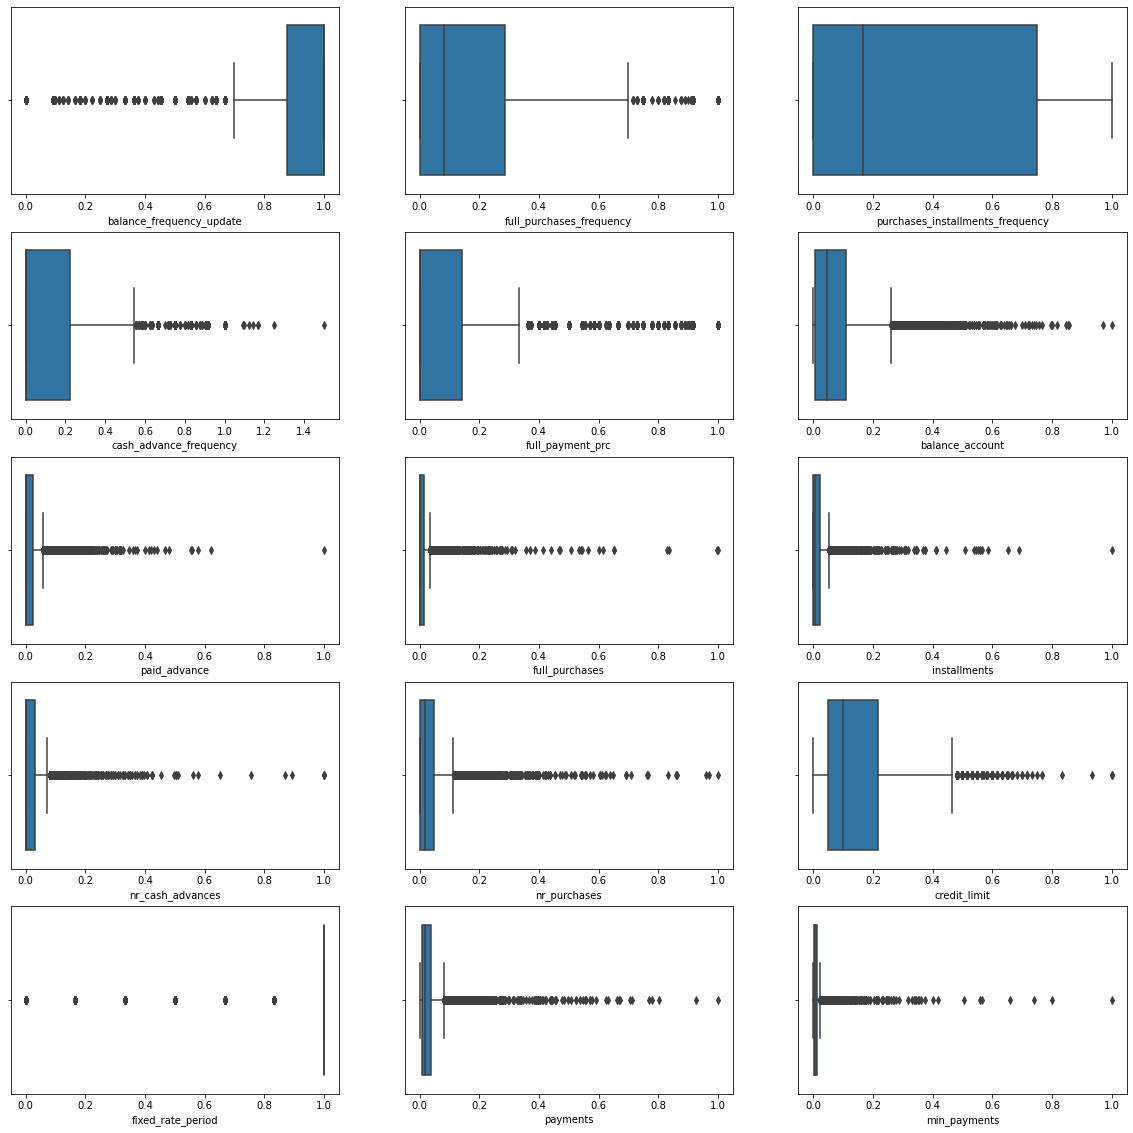

In [17]:
fig, axs = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(20, 20))
for index, name in enumerate(df.columns):
    col = index % 3
    row = (index - col) // 3
    ax = axs[row][col]
    sns.boxplot(ax=ax, data=df, x=name)

In [18]:
df = df.drop(
    "credit_limit", axis=1
)  # this feature is dropped because it is not a client feature. it is decided by the bank

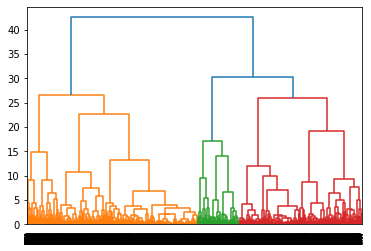

In [19]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(
    sch.linkage(df, method="ward")
)  # to get the number of clusters.
# find the longest horizontal distance without any branching. That is the optimal number of clusters

In [20]:
model = AgglomerativeClustering(
    n_clusters=6, affinity="euclidean", linkage="ward"
)  # model with 6 number of clusters
model.fit_predict(df)
labels = model.labels_

For n_clusters = 2 The average silhouette_score is : 0.3163
For n_clusters = 3 The average silhouette_score is : 0.323
For n_clusters = 4 The average silhouette_score is : 0.3158
For n_clusters = 5 The average silhouette_score is : 0.3178
For n_clusters = 6 The average silhouette_score is : 0.336
For n_clusters = 7 The average silhouette_score is : 0.3429


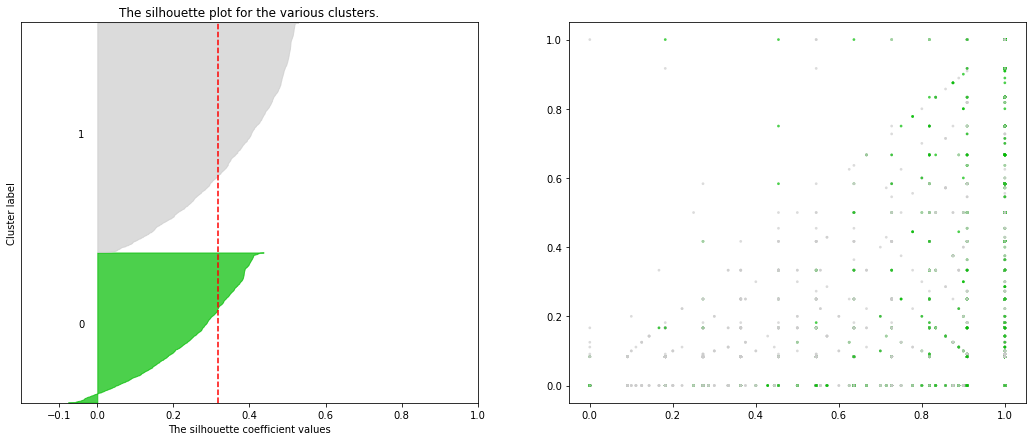

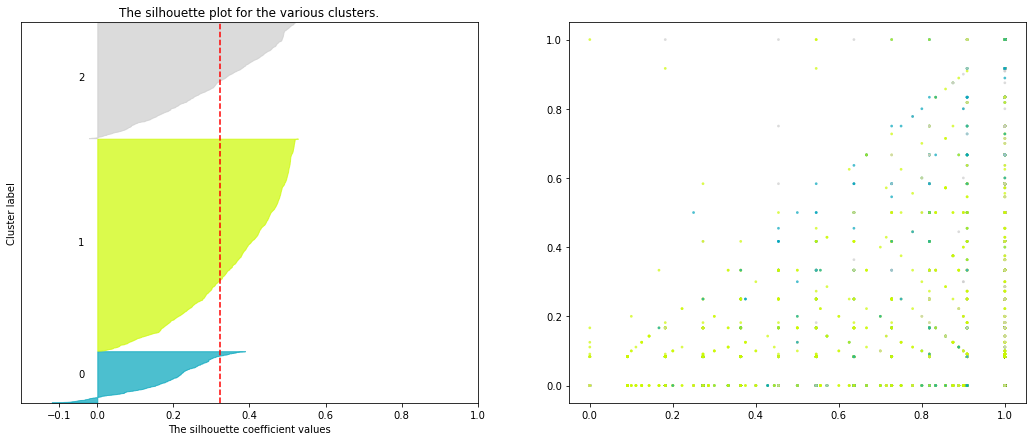

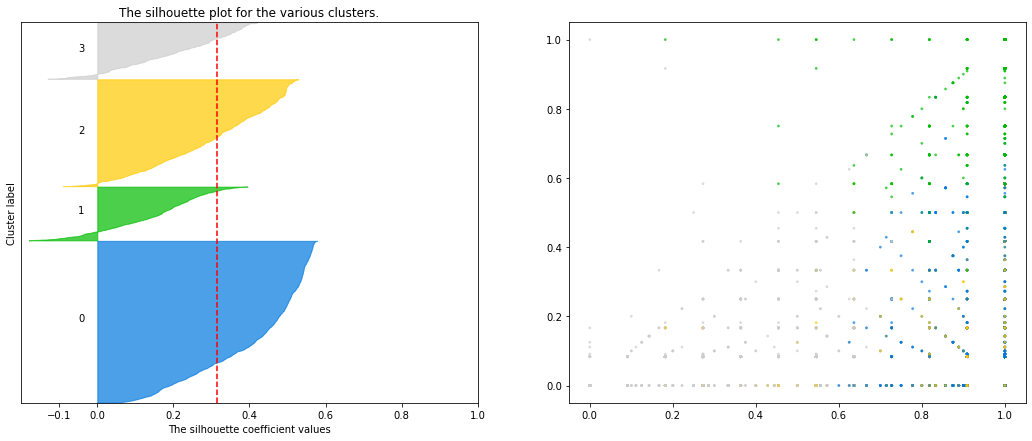

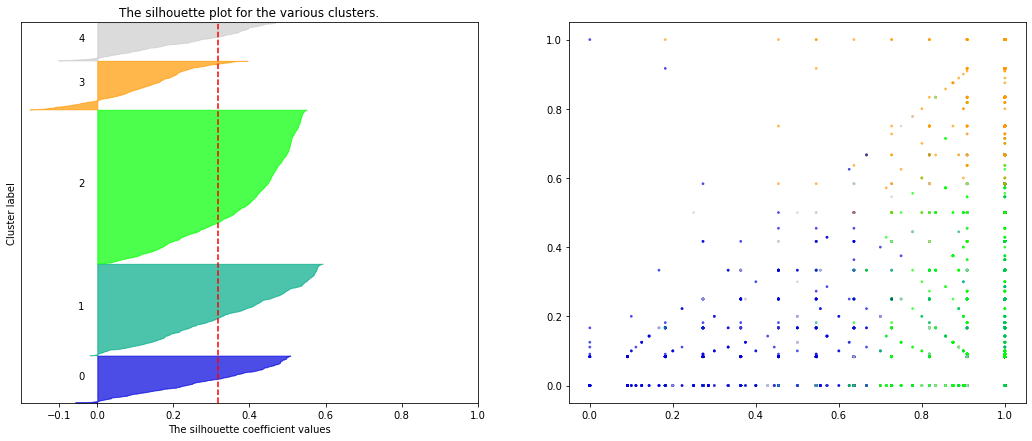

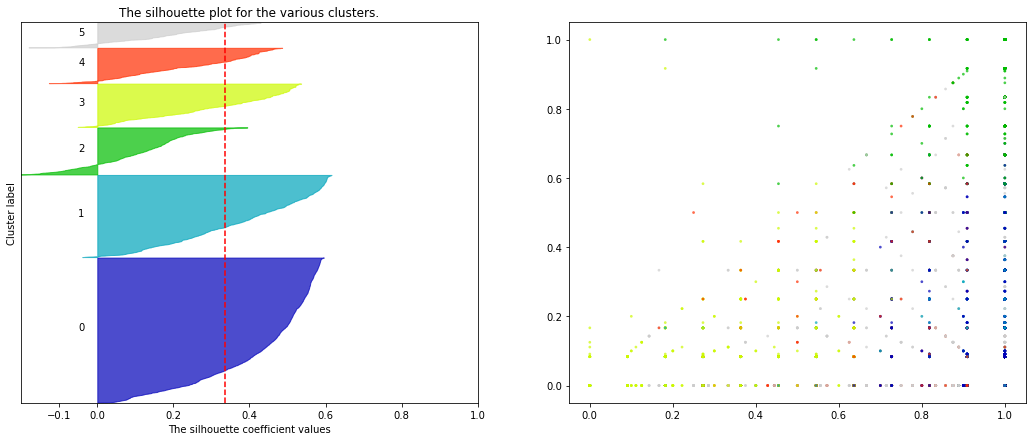

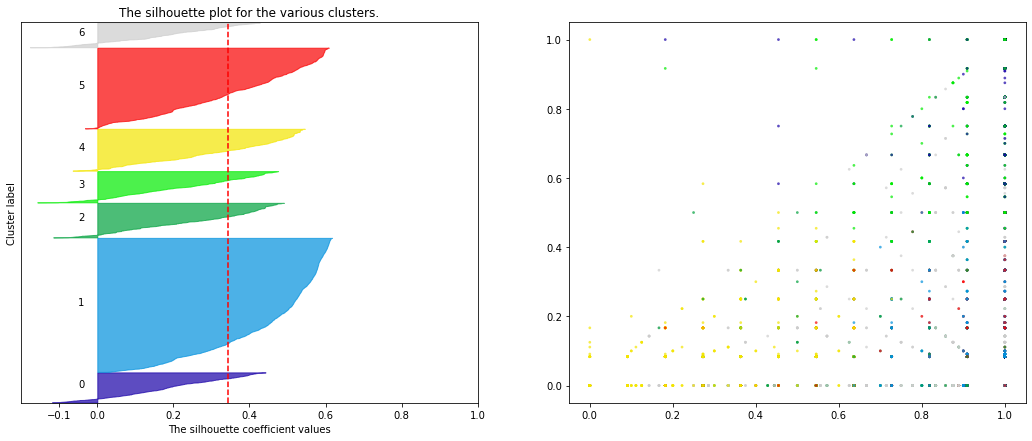

In [21]:
X = df.to_numpy()

""" Note: The code below is directly took from sklearn documentation of silhoutte analysis.
          And so you do not have to spend time trying to understand the code"""

range_n_clusters = range(2, 8)

r_seed = 17

cols = df.columns

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline(
        [
            ("scaler", None),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
        ]
    )

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg.round(4),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    # centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2255
For n_clusters = 3 The average silhouette_score is : 0.2282
For n_clusters = 4 The average silhouette_score is : 0.2453
For n_clusters = 5 The average silhouette_score is : 0.2448
For n_clusters = 6 The average silhouette_score is : 0.231
For n_clusters = 7 The average silhouette_score is : 0.2404


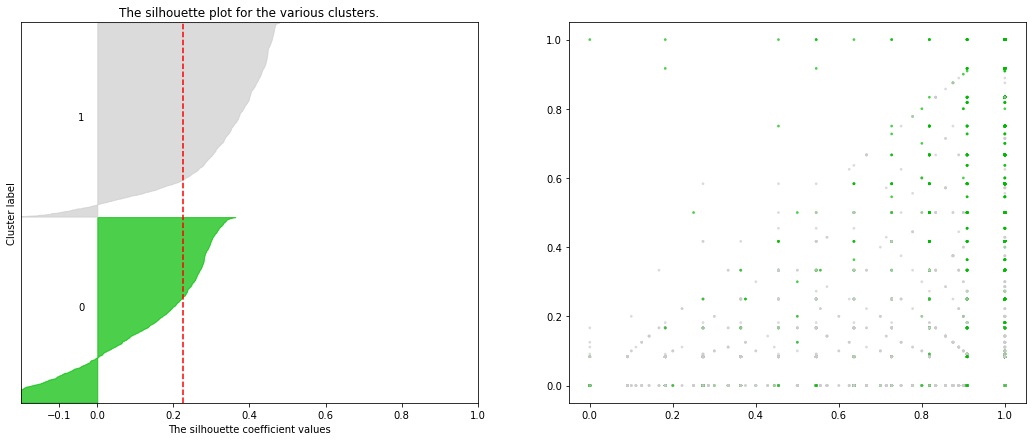

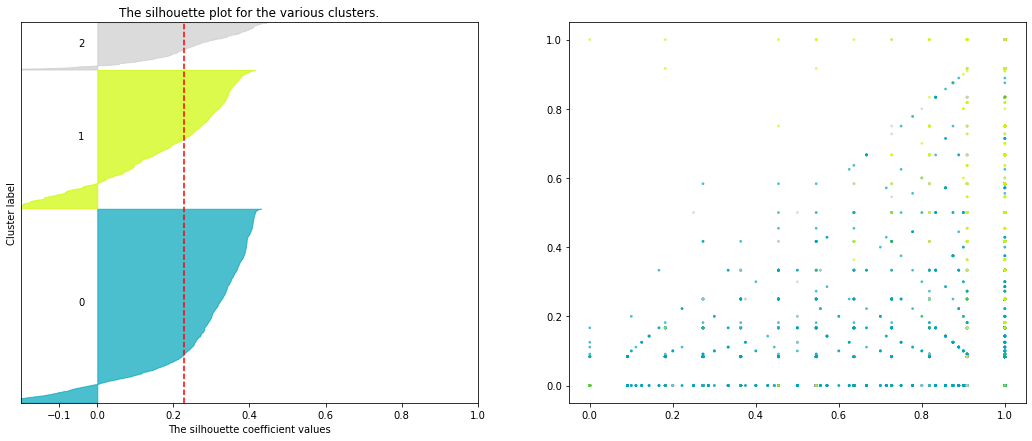

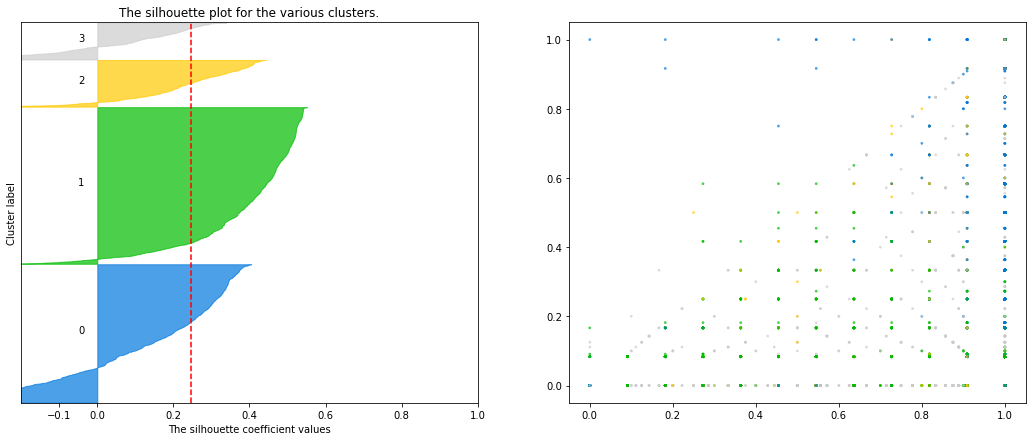

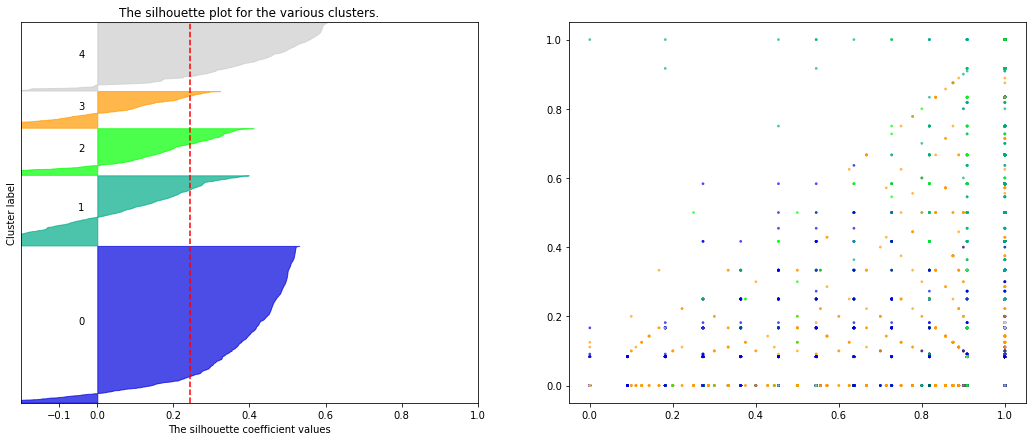

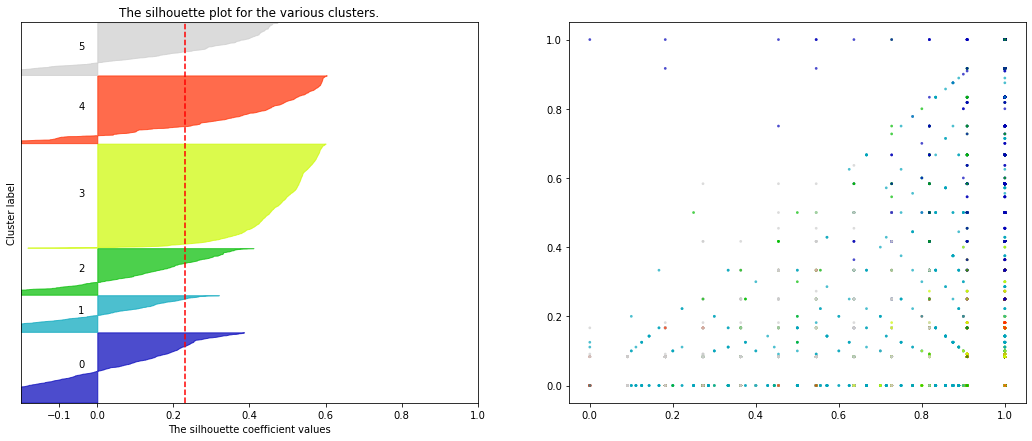

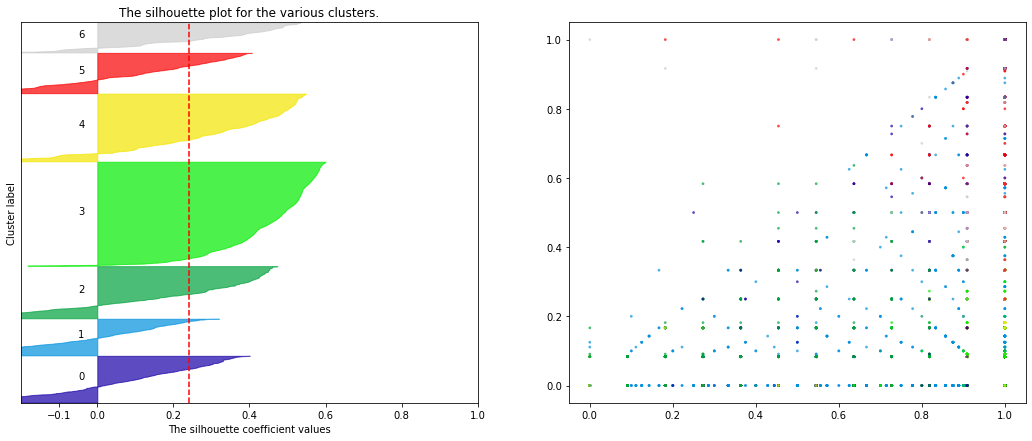

In [22]:
X = df.to_numpy()

""" Note: The code below is directly took from sklearn documentation of silhoutte analysis.
          And so you do not have to spend time trying to understand the code"""

range_n_clusters = range(2, 8)

r_seed = 17

cols = df.columns

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline(
        [
            ("scaler", None),
            (
                "cluster",
                AgglomerativeClustering(
                    n_clusters=n_clusters, affinity="euclidean", linkage="ward"
                ),
            ),
        ]
    )

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg.round(4),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    # pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    # centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2255
For n_clusters = 3 The average silhouette_score is : 0.2282
For n_clusters = 4 The average silhouette_score is : 0.2453
For n_clusters = 5 The average silhouette_score is : 0.2448
For n_clusters = 6 The average silhouette_score is : 0.231
For n_clusters = 7 The average silhouette_score is : 0.2404


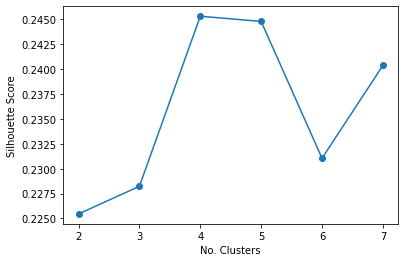

In [23]:
from sklearn.cluster import AgglomerativeClustering

silhouette_s = []

for n_clusters in range(2, 8):
    agglo_pipeline = Pipeline(
        [("scaler", None), ("cluster", AgglomerativeClustering(n_clusters=n_clusters))]
    )

    cluster_labels = agglo_pipeline.fit_predict(df)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_score(df, cluster_labels).round(4),
    )
    silhouette_s.append(silhouette_score(df, cluster_labels))

plt.plot(range(2, 8), silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3163
For n_clusters = 3 The average silhouette_score is : 0.3229
For n_clusters = 4 The average silhouette_score is : 0.3158
For n_clusters = 5 The average silhouette_score is : 0.3178
For n_clusters = 6 The average silhouette_score is : 0.3354
For n_clusters = 7 The average silhouette_score is : 0.3423


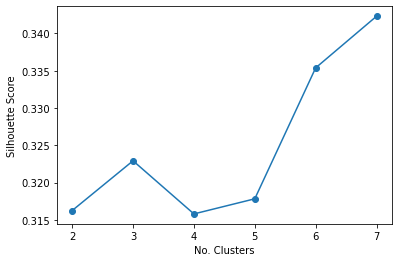

In [24]:
silhouette_s = []

for n_clusters in range(2, 8):
    kmeans_pipeline = Pipeline(
        [("scaler", None), ("cluster", KMeans(n_clusters=n_clusters))]
    )

    cluster_labels = kmeans_pipeline.fit_predict(df)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_score(df, cluster_labels).round(4),
    )
    silhouette_s.append(silhouette_score(df, cluster_labels))

plt.plot(range(2, 8), silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.show()

<AxesSubplot:>

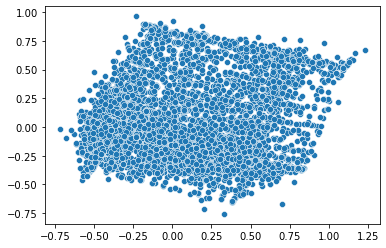

In [25]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(df)
Y_sklearn

sns.scatterplot(x=Y_sklearn[:, 0], y=Y_sklearn[:, 1])

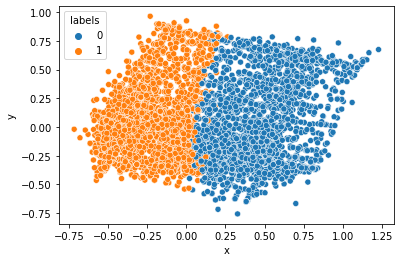

In [26]:
for n_clusters in [2]:
    sklearn_pca = sklearnPCA(n_components=2)
    Y_sklearn = sklearn_pca.fit_transform(df)
    model = KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)
    model.fit_predict(df)
    labels = model.labels_
    df1 = pd.DataFrame(Y_sklearn, columns=["x", "y"])
    df1["labels"] = labels
    sns.scatterplot(data=df1, x="x", y="y", hue="labels")

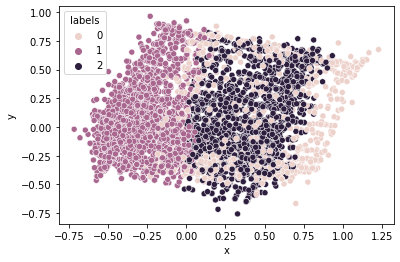

In [27]:
for n_clusters in [3]:
    sklearn_pca = sklearnPCA(n_components=2)
    Y_sklearn = sklearn_pca.fit_transform(df)
    model = KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)
    model.fit_predict(df)
    labels = model.labels_
    df1 = pd.DataFrame(Y_sklearn, columns=["x", "y"])
    df1["labels"] = labels
    sns.scatterplot(data=df1, x="x", y="y", hue="labels")

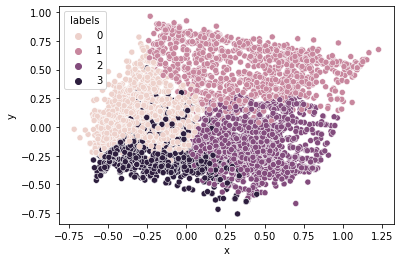

In [28]:
for n_clusters in [4]:
    sklearn_pca = sklearnPCA(n_components=2)
    Y_sklearn = sklearn_pca.fit_transform(df)
    model = KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)
    model.fit_predict(df)
    labels = model.labels_
    df1 = pd.DataFrame(Y_sklearn, columns=["x", "y"])
    df1["labels"] = labels
    sns.scatterplot(data=df1, x="x", y="y", hue="labels")

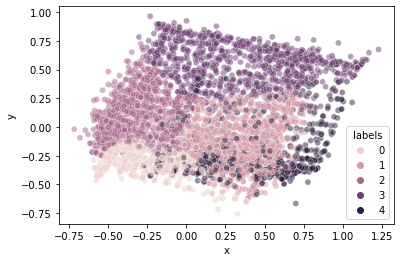

In [29]:
for n_clusters in [5]:
    sklearn_pca = sklearnPCA(n_components=2)
    Y_sklearn = sklearn_pca.fit_transform(df)
    model = KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)
    model.fit_predict(df)
    labels = model.labels_
    df1 = pd.DataFrame(Y_sklearn, columns=["x", "y"])
    df1["labels"] = labels
    sns.scatterplot(data=df1, x="x", y="y", hue="labels", alpha=0.5)

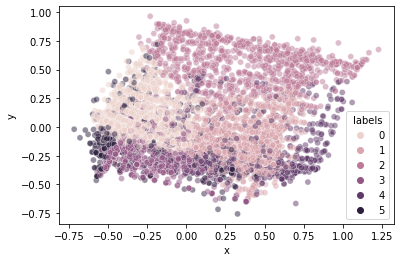

In [30]:
for n_clusters in [6]:
    sklearn_pca = sklearnPCA(n_components=2)
    Y_sklearn = sklearn_pca.fit_transform(df)
    model = KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)
    model.fit_predict(df)
    labels = model.labels_
    df1 = pd.DataFrame(Y_sklearn, columns=["x", "y"])
    df1["labels"] = labels
    sns.scatterplot(data=df1, x="x", y="y", hue="labels", alpha=0.5)

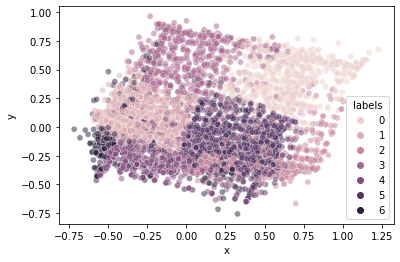

In [31]:
for n_clusters in [7]:
    sklearn_pca = sklearnPCA(n_components=2)
    Y_sklearn = sklearn_pca.fit_transform(df)
    model = KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)
    model.fit_predict(df)
    labels = model.labels_
    df1 = pd.DataFrame(Y_sklearn, columns=["x", "y"])
    df1["labels"] = labels
    sns.scatterplot(data=df1, x="x", y="y", hue="labels", alpha=0.5)

In [32]:
# we do the labeling with 4 classees and k-means model
X = df.copy()
model = KMeans(n_clusters=4, random_state=42, verbose=0)
labels = model.fit_predict(X)

In [33]:
df["labels"] = labels

In [34]:
df.labels.value_counts()

3    3630
0    2402
1    1260
2    1208
Name: labels, dtype: int64

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=42)

y = df["labels"].copy()

gbm.fit(X, y)
y_pred = gbm.predict(X)
class_labels = gbm.classes_
print(classification_report(y, y_pred))

print(
    pd.DataFrame(confusion_matrix(y, y_pred), columns=class_labels, index=class_labels)
)

feat_imp = gbm.feature_importances_  # get feature importances from the model
features = X.columns

feature_importance = pd.DataFrame(
    list(zip(features, feat_imp)), columns=["Feature", "Importance"]
)

feature_importance.sort_values("Importance", ascending=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2402
           1       1.00      1.00      1.00      1260
           2       1.00      1.00      1.00      1208
           3       1.00      1.00      1.00      3630

    accuracy                           1.00      8500
   macro avg       1.00      1.00      1.00      8500
weighted avg       1.00      1.00      1.00      8500

      0     1     2     3
0  2402     0     0     0
1     1  1257     0     2
2     2     0  1205     1
3     1     1     1  3627


,Feature,Importance
2,purchases_installments_frequency,0.376460
1,full_purchases_frequency,0.303212
0,balance_frequency_update,0.278013
5,balance_account,0.011987
4,full_payment_prc,0.009805
8,installments,0.008454
3,cash_advance_frequency,0.006005
9,nr_cash_advances,0.001791
10,nr_purchases,0.001754
6,paid_advance,0.000825


<AxesSubplot:xlabel='purchases_installments_frequency', ylabel='full_purchases_frequency'>

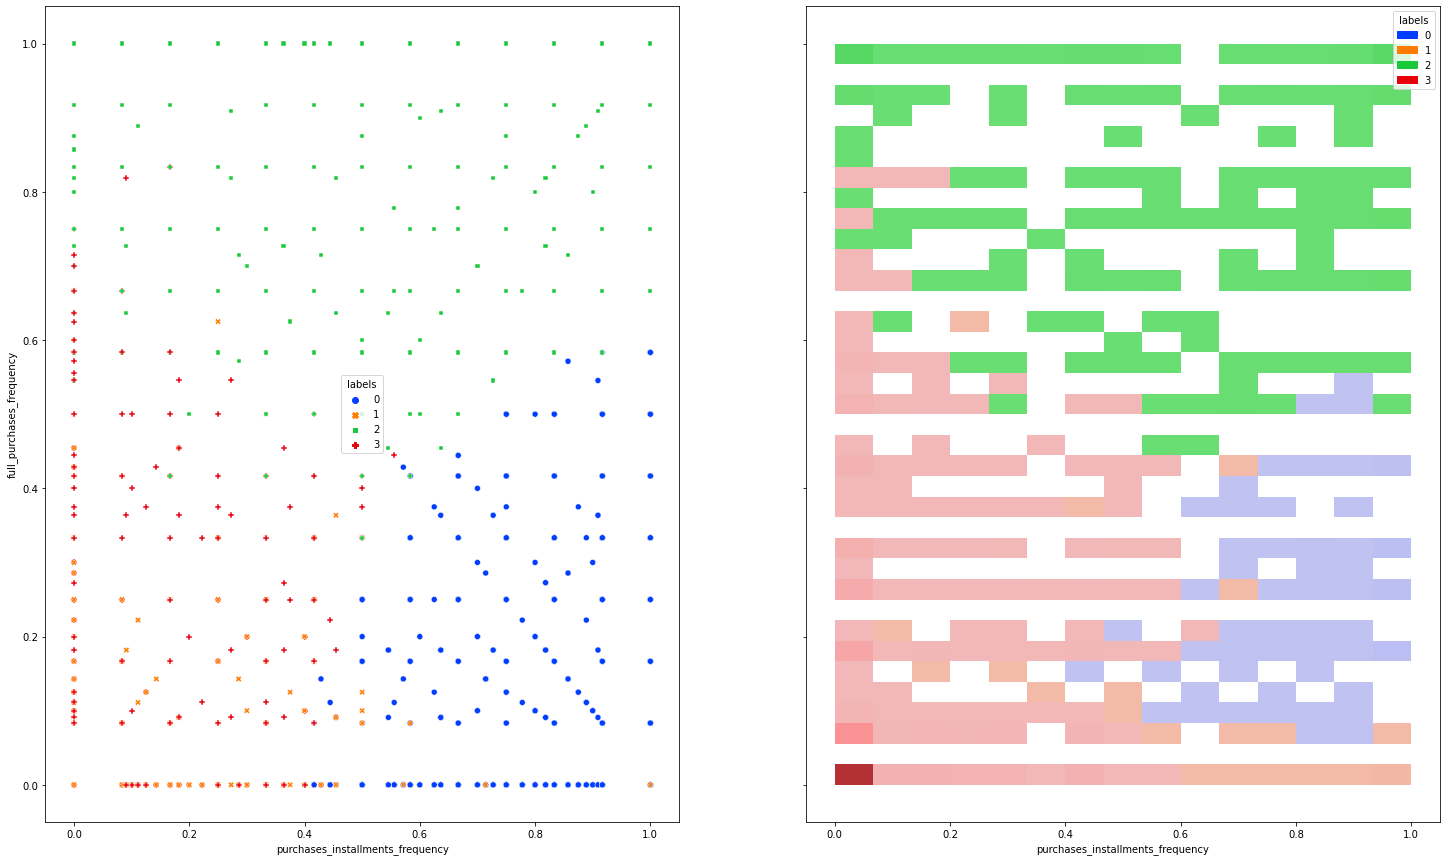

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True)
sns.scatterplot(
    ax=axes[0],
    data=df,
    x="purchases_installments_frequency",
    y="full_purchases_frequency",
    hue="labels",
    style="labels",
    palette="bright",
)
sns.histplot(
    ax=axes[1],
    data=df,
    x="purchases_installments_frequency",
    y="full_purchases_frequency",
    hue="labels",
    palette="bright",
)

<AxesSubplot:xlabel='purchases_installments_frequency', ylabel='balance_frequency_update'>

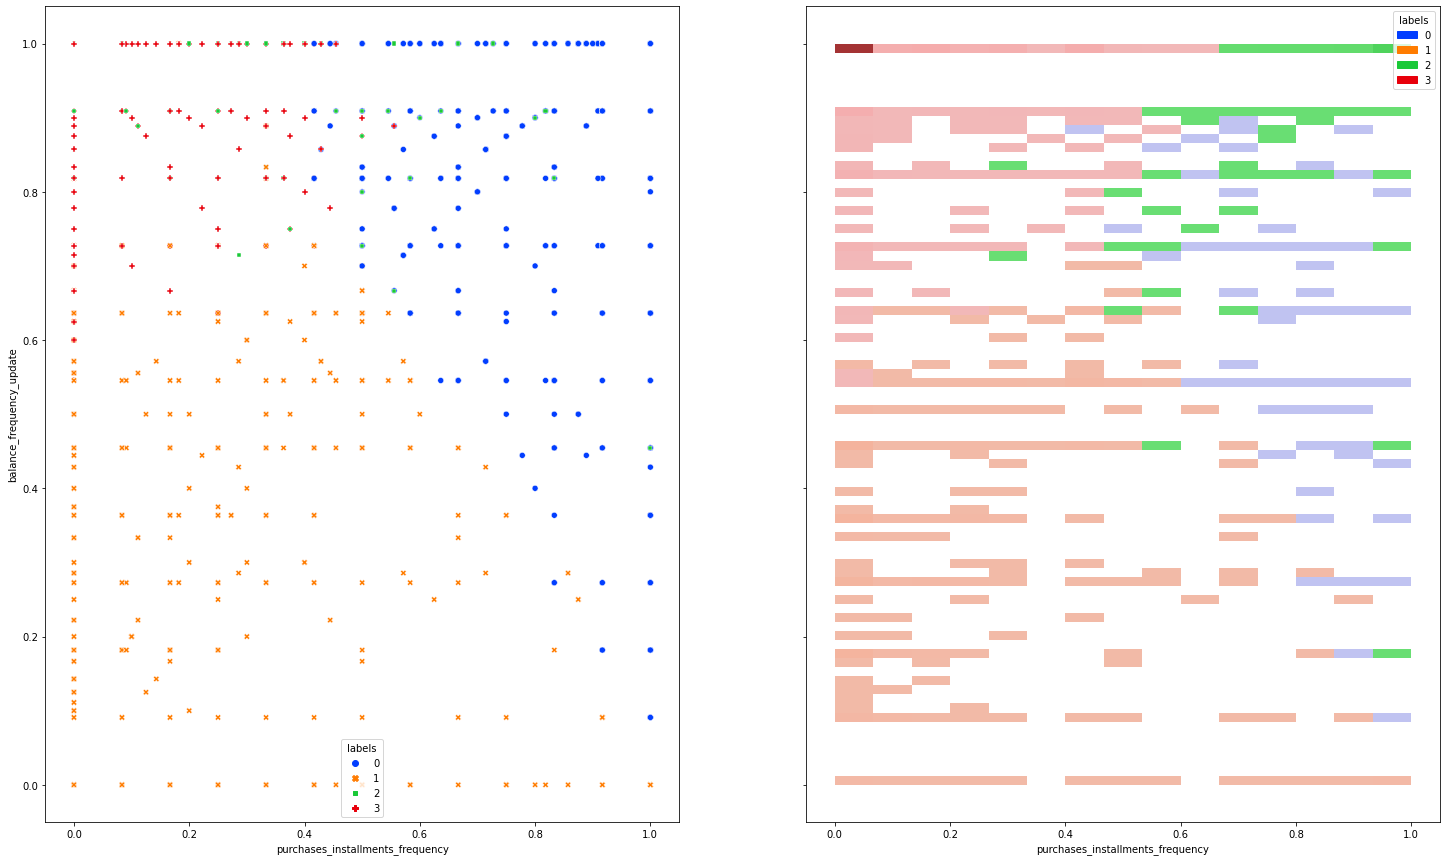

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True)
sns.scatterplot(
    ax=axes[0],
    data=df,
    x="purchases_installments_frequency",
    y="balance_frequency_update",
    hue="labels",
    style="labels",
    palette="bright",
)
sns.histplot(
    ax=axes[1],
    data=df,
    x="purchases_installments_frequency",
    y="balance_frequency_update",
    hue="labels",
    palette="bright",
)

<AxesSubplot:xlabel='full_purchases_frequency', ylabel='balance_frequency_update'>

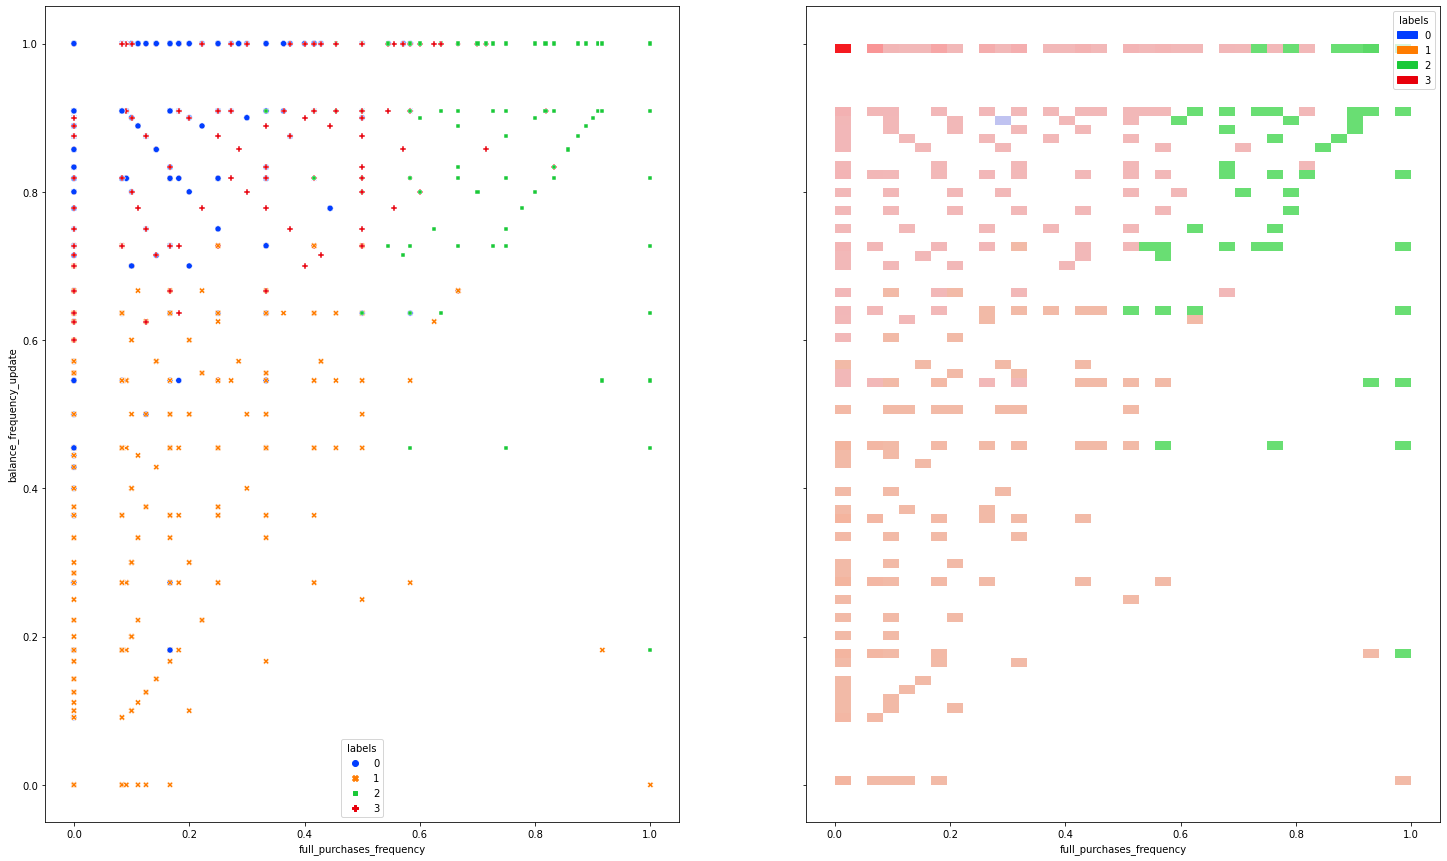

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True)
sns.scatterplot(
    ax=axes[0],
    data=df,
    x="full_purchases_frequency",
    y="balance_frequency_update",
    hue="labels",
    style="labels",
    palette="bright",
)
sns.histplot(
    ax=axes[1],
    data=df,
    x="full_purchases_frequency",
    y="balance_frequency_update",
    hue="labels",
    palette="bright",
)

Text(0.5, 1.0, 'installments')

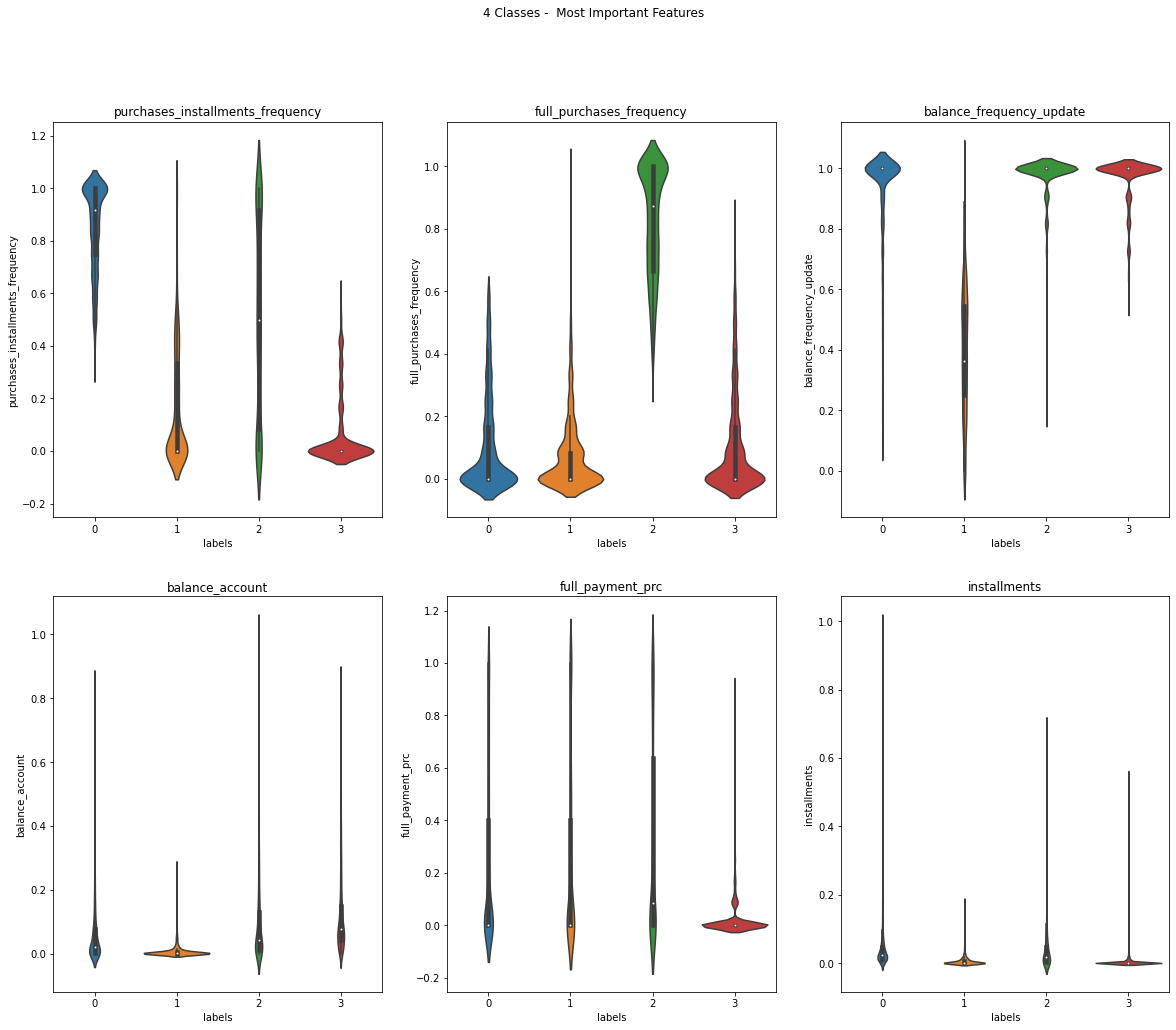

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(20, 16), sharey=False)
fig.suptitle("4 Classes -  Most Important Features")
sns.violinplot(ax=axes[0, 0], data=df, x="labels", y="purchases_installments_frequency")
axes[0, 0].set_title("purchases_installments_frequency")
sns.violinplot(ax=axes[0, 1], data=df, x="labels", y="full_purchases_frequency")
axes[0, 1].set_title("full_purchases_frequency")
sns.violinplot(ax=axes[0, 2], data=df, x="labels", y="balance_frequency_update")
axes[0, 2].set_title("balance_frequency_update")
sns.violinplot(ax=axes[1, 0], data=df, x="labels", y="balance_account")
axes[1, 0].set_title("balance_account")
sns.violinplot(ax=axes[1, 1], data=df, x="labels", y="full_payment_prc")
axes[1, 1].set_title("full_payment_prc")
sns.violinplot(ax=axes[1, 2], data=df, x="labels", y="installments")
axes[1, 2].set_title("installments")

In [40]:
# try with 3 classes
model = KMeans(n_clusters=3, random_state=42, verbose=0)
labels = model.fit_predict(df)
df["labels"] = labels
print(df.labels.value_counts())

0    3630
2    2468
1    2402
Name: labels, dtype: int64


Text(0.5, 1.0, 'installments')

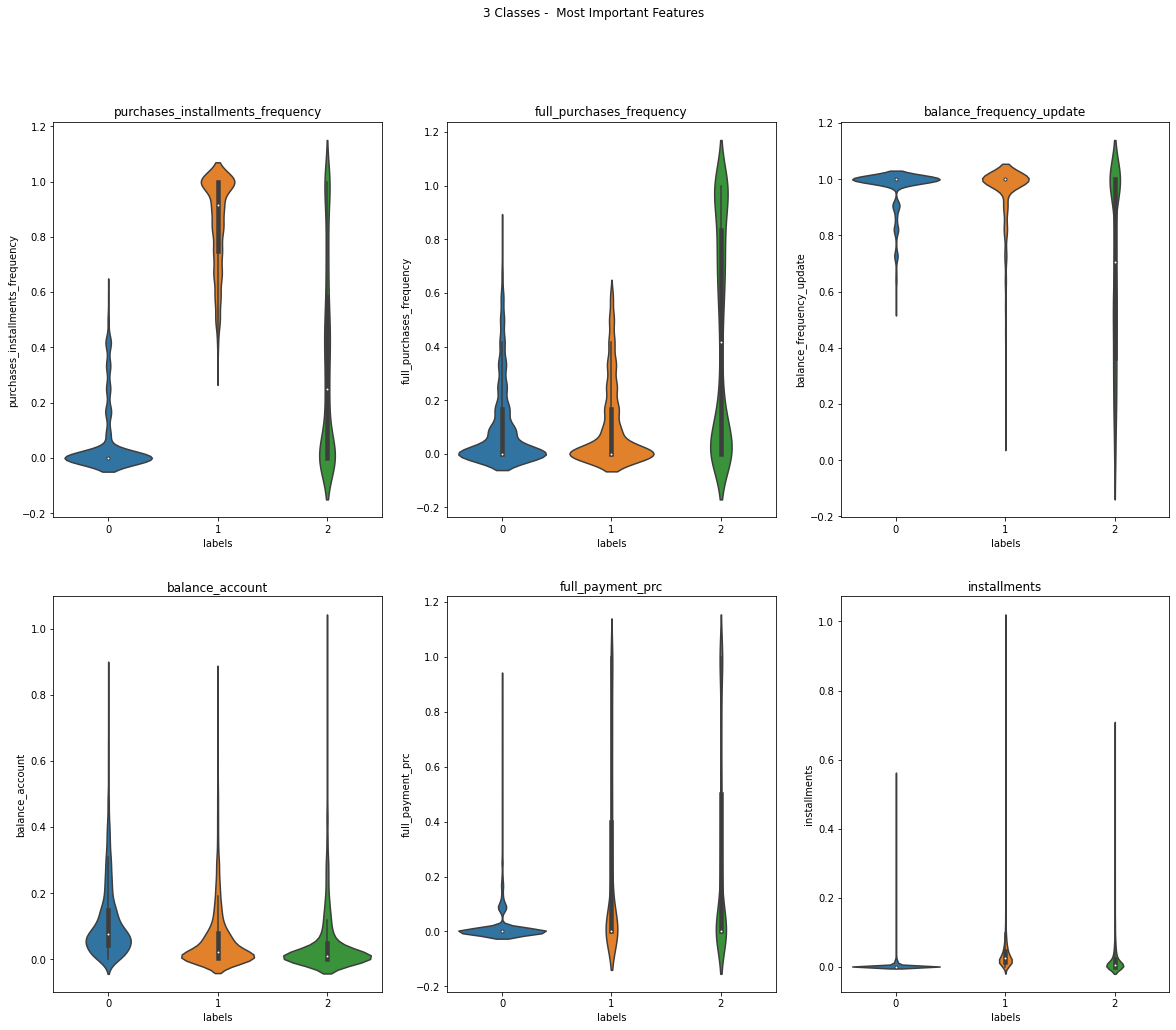

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(20, 16), sharey=False)
fig.suptitle("3 Classes -  Most Important Features")
sns.violinplot(ax=axes[0, 0], data=df, x="labels", y="purchases_installments_frequency")
axes[0, 0].set_title("purchases_installments_frequency")
sns.violinplot(ax=axes[0, 1], data=df, x="labels", y="full_purchases_frequency")
axes[0, 1].set_title("full_purchases_frequency")
sns.violinplot(ax=axes[0, 2], data=df, x="labels", y="balance_frequency_update")
axes[0, 2].set_title("balance_frequency_update")
sns.violinplot(ax=axes[1, 0], data=df, x="labels", y="balance_account")
axes[1, 0].set_title("balance_account")
sns.violinplot(ax=axes[1, 1], data=df, x="labels", y="full_payment_prc")
axes[1, 1].set_title("full_payment_prc")
sns.violinplot(ax=axes[1, 2], data=df, x="labels", y="installments")
axes[1, 2].set_title("installments")

1    4870
0    3630
Name: labels, dtype: int64


Text(0.5, 1.0, 'installments')

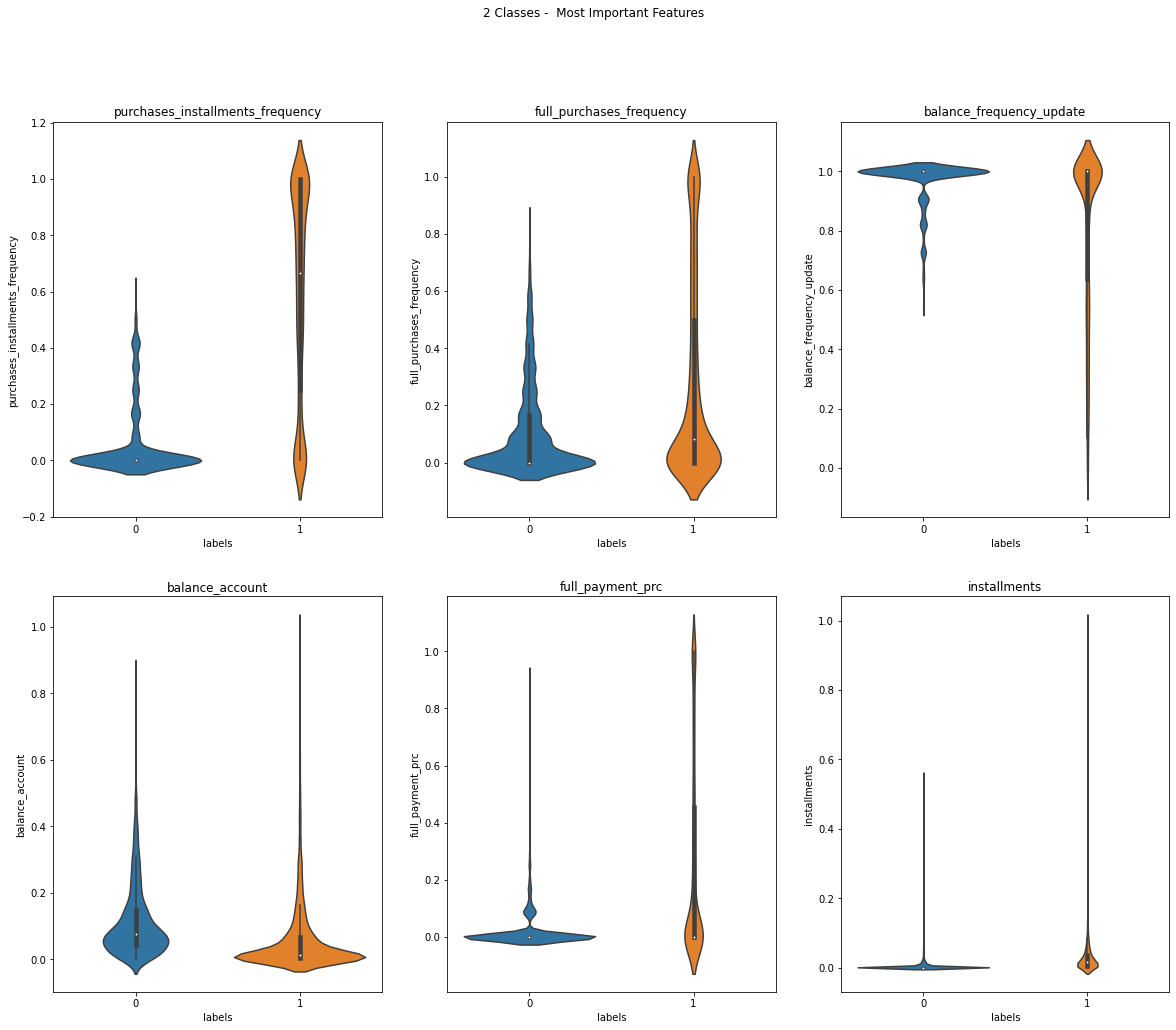

In [42]:
# try with 2 classes
model = KMeans(n_clusters=2, random_state=42, verbose=0)
labels = model.fit_predict(df)
df["labels"] = labels
print(df.labels.value_counts())

fig, axes = plt.subplots(2, 3, figsize=(20, 16), sharey=False)
fig.suptitle("2 Classes -  Most Important Features")
sns.violinplot(ax=axes[0, 0], data=df, x="labels", y="purchases_installments_frequency")
axes[0, 0].set_title("purchases_installments_frequency")
sns.violinplot(ax=axes[0, 1], data=df, x="labels", y="full_purchases_frequency")
axes[0, 1].set_title("full_purchases_frequency")
sns.violinplot(ax=axes[0, 2], data=df, x="labels", y="balance_frequency_update")
axes[0, 2].set_title("balance_frequency_update")
sns.violinplot(ax=axes[1, 0], data=df, x="labels", y="balance_account")
axes[1, 0].set_title("balance_account")
sns.violinplot(ax=axes[1, 1], data=df, x="labels", y="full_payment_prc")
axes[1, 1].set_title("full_payment_prc")
sns.violinplot(ax=axes[1, 2], data=df, x="labels", y="installments")
axes[1, 2].set_title("installments")